In [19]:
import zipfile
import pandas as pd

# ---------- 1. Charger les trois fichiers ----------

def read_french_zip(path):
    z = zipfile.ZipFile(path)
    csv_name = [f for f in z.namelist() if f.lower().endswith(".csv")][0]
    text = z.read(csv_name).decode("latin1")
    return text

# chemins vers tes fichiers dans VS Code
path_ff5   = "data/F-F_Research_Data_5_Factors_2x3_CSV.zip"
path_mom   = "data/F-F_Momentum_Factor_CSV.zip"
path_ind17 = "data/17_Industry_Portfolios_CSV.zip"

txt_ff5   = read_french_zip(path_ff5)
txt_mom   = read_french_zip(path_mom)
txt_ind17 = read_french_zip(path_ind17)

# parse_french_monthly = la fonction que tu as déjà définie

ff5   = parse_french_monthly(txt_ff5)    # 5 facteurs + RF
mom   = parse_french_monthly(txt_mom)    # Momentum
ind17 = parse_french_monthly(txt_ind17)  # 17 industries

mom.columns = ["UMD"]  # nom propre du facteur momentum

# ---------- 2. Restreindre à 1980–2021 ----------

debut = "1980-01-01"
fin   = "2021-12-31"

ff5_80_21   = ff5.loc[debut:fin]
mom_80_21   = mom.loc[debut:fin]
ind17_80_21 = ind17.loc[debut:fin]

# ---------- 3. Aligner exactement les dates ----------

idx_commune = ff5_80_21.index.intersection(mom_80_21.index).intersection(ind17_80_21.index)

ff5_80_21   = ff5_80_21.loc[idx_commune]
mom_80_21   = mom_80_21.loc[idx_commune]
ind17_80_21 = ind17_80_21.loc[idx_commune]

print("Période finale :", ff5_80_21.index.min().date(), "→", ff5_80_21.index.max().date())
print("Nombre d'observations mensuelles :", len(ff5_80_21))


Période finale : 1980-01-01 → 2021-12-01
Nombre d'observations mensuelles : 504


In [26]:
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) FONCTIONS DE CHARGEMENT & PARSING KEN FRENCH
# ---------------------------------------------------

def read_french_zip(path):
    """Lit le contenu texte du CSV contenu dans un ZIP Ken French."""
    z = zipfile.ZipFile(path)
    csv_name = [f for f in z.namelist() if f.lower().endswith(".csv")][0]
    return z.read(csv_name).decode("latin1")

def parse_french_monthly(txt):
    """Parse le CSV Ken French en conservant l'en-tête et la section mensuelle."""
    lignes = txt.splitlines()

    # Trouver début mensuel (yyyyMM)
    debut = None
    for i, ligne in enumerate(lignes):
        premier = ligne.split(",")[0].strip()
        if premier.isdigit() and len(premier) == 6:
            debut = i
            break

    # Trouver l'en-tête juste avant
    entete = None
    for j in range(debut - 1, -1, -1):
        if "," in lignes[j]:
            entete = j
            break

    # Trouver la fin (avant Annual)
    fin = None
    for k in range(debut + 1, len(lignes)):
        if lignes[k].strip() == "" or "Annual" in lignes[k]:
            fin = k
            break
    if fin is None:
        fin = len(lignes)

    # Extraction
    bloc = "\n".join(lignes[entete:fin])
    df = pd.read_csv(io.StringIO(bloc))

    # Conversion date
    date_col = df.columns[0]
    df["date"] = pd.to_datetime(df[date_col].astype(str), format="%Y%m", errors="coerce")
    df = df.dropna(subset=["date"]).set_index("date")
    df = df.drop(columns=[date_col])

    # Conversion numérique
    df = df.apply(pd.to_numeric, errors="coerce")

    return df

# ---------------------------------------------------
# 2) CHARGER LES TROIS FICHIERS
# ---------------------------------------------------
ff5_txt   = read_french_zip("data/F-F_Research_Data_5_Factors_2x3_CSV.zip")
mom_txt   = read_french_zip("data/F-F_Momentum_Factor_CSV.zip")
ind_txt   = read_french_zip("data/17_Industry_Portfolios_CSV.zip")

ff5   = parse_french_monthly(ff5_txt)      # Mkt-RF, SMB, HML, RMW, CMA, RF
mom   = parse_french_monthly(mom_txt)      # momentum UMD
ind17 = parse_french_monthly(ind_txt)      # 17 industries

mom.columns = ["UMD"]                      # renommer proprement la colonne

# ---------------------------------------------------
# 3) FILTRER 1980–2021 & ALIGNER EXACTEMENT
# ---------------------------------------------------
start = "1980-01-01"
end   = "2021-12-31"

ff5 = ff5.loc[start:end]
mom = mom.loc[start:end]
ind17 = ind17.loc[start:end]

idx = ff5.index.intersection(mom.index).intersection(ind17.index)
ff5, mom, ind17 = ff5.loc[idx], mom.loc[idx], ind17.loc[idx]

# ---------------------------------------------------
# 4) CONSTRUIRE LE DATAFRAME FINAL (6 facteurs + 17 industries)
# ---------------------------------------------------
factors = pd.concat([ff5[["Mkt-RF","SMB","HML","RMW","CMA","RF"]], mom], axis=1)
full_df = pd.concat([factors, ind17], axis=1)

print("Forme du DataFrame final :", full_df.shape)

print("=== Statistiques descriptives 1980–2021 ===")
print(stats)


Forme du DataFrame final : (504, 24)
=== Statistiques descriptives 1980–2021 ===
           Mkt-RF         SMB         HML         RMW         CMA          RF  \
count  504.000000  504.000000  504.000000  504.000000  504.000000  504.000000   
mean     0.743333    0.095198    0.203155    0.374187    0.251905    0.330317   
std      4.476091    2.896355    3.028519    2.403614    1.972099    0.293623   
min    -23.190000  -15.540000  -13.830000  -18.950000   -6.410000    0.000000   
25%     -1.912500   -1.587500   -1.505000   -0.755000   -1.020000    0.060000   
50%      1.180000    0.005000    0.055000    0.315000    0.080000    0.320000   
75%      3.482500    1.872500    1.755000    1.372500    1.475000    0.482500   
max     13.580000   18.460000   12.240000   13.050000    9.010000    1.350000   

              UMD        Food       Mines         Oil  ...       Cnstr  \
count  504.000000  504.000000  504.000000  504.000000  ...  504.000000   
mean     0.524266    1.210000    0.951806

In [25]:
# Statistiques pour les 7 facteurs
stats_factors = full_df[["Mkt-RF","SMB","HML","RMW","CMA","RF","UMD"]].describe()
print("\n=== Statistiques descriptive des facteurs ===")
print(stats_factors)

# Statistiques pour les 17 industries
industrie_cols = ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum',
                  'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans',
                  'Utils', 'Rtail', 'Finan', 'Other']

stats_industries = full_df[industrie_cols].describe()
print("\n=== Statistiques descriptives des 17 industries ===")
print(stats_industries)



=== Statistiques descriptive des facteurs ===
           Mkt-RF         SMB         HML         RMW         CMA          RF  \
count  504.000000  504.000000  504.000000  504.000000  504.000000  504.000000   
mean     0.743333    0.095198    0.203155    0.374187    0.251905    0.330317   
std      4.476091    2.896355    3.028519    2.403614    1.972099    0.293623   
min    -23.190000  -15.540000  -13.830000  -18.950000   -6.410000    0.000000   
25%     -1.912500   -1.587500   -1.505000   -0.755000   -1.020000    0.060000   
50%      1.180000    0.005000    0.055000    0.315000    0.080000    0.320000   
75%      3.482500    1.872500    1.755000    1.372500    1.475000    0.482500   
max     13.580000   18.460000   12.240000   13.050000    9.010000    1.350000   

              UMD  
count  504.000000  
mean     0.524266  
std      4.478624  
min    -34.340000  
25%     -1.192500  
50%      0.605000  
75%      2.840000  
max     18.020000  

=== Statistiques descriptives des 17 indus

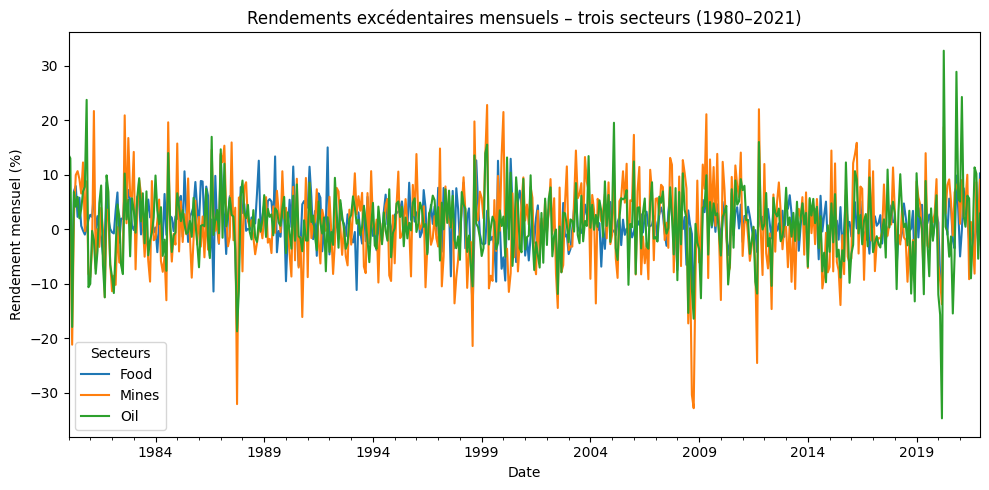

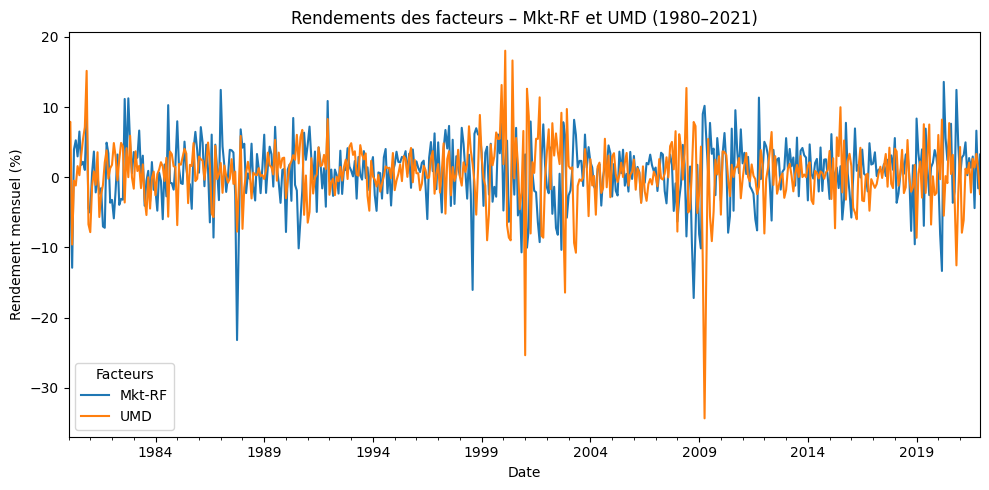

In [35]:
secteurs = ["Food", "Mines", "Oil"]   # tu peux changer les noms ici

plt.figure(figsize=(10, 5))
full_df[secteurs].plot(ax=plt.gca())
plt.title("Rendements excédentaires mensuels – trois secteurs (1980–2021)")
plt.xlabel("Date")
plt.ylabel("Rendement mensuel (%)")
plt.legend(title="Secteurs")
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Graphique pour 2 facteurs
# -----------------------------
facteurs = ["Mkt-RF", "UMD"]          # par ex. marché et momentum

plt.figure(figsize=(10, 5))
full_df[facteurs].plot(ax=plt.gca())
plt.title("Rendements des facteurs – Mkt-RF et UMD (1980–2021)")
plt.xlabel("Date")
plt.ylabel("Rendement mensuel (%)")
plt.legend(title="Facteurs")
plt.tight_layout()
plt.show()

In [27]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# ===============================
# 1) Définition des secteurs et facteurs
# ===============================

factors_list = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]

sector_list = ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum',
               'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans',
               'Utils', 'Rtail', 'Finan', 'Other']

# dataframe des facteurs
F = full_df[factors_list]

# dataframe des rendements excédentaires sectoriels
R = full_df[sector_list]


# ===============================
# 2) Estimation OLS secteur par secteur
# ===============================

results = {}
betas = pd.DataFrame(index=sector_list, columns=factors_list)
alphas = pd.Series(index=sector_list, dtype=float)
tstats = pd.DataFrame(index=sector_list, columns=["alpha"] + factors_list)
r2 = pd.Series(index=sector_list, dtype=float)

for sector in sector_list:
    
    y = R[sector]                                  # rendement excédentaire du secteur i
    X = sm.add_constant(F)                         # constante + six facteurs
    
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 6}) # NEWEY–WEST
    
    alphas[sector] = model.params["const"]
    betas.loc[sector, :] = model.params[factors_list]
    
    # t-stat robustes
    tstats.loc[sector, "alpha"] = model.tvalues["const"]
    for f in factors_list:
        tstats.loc[sector, f] = model.tvalues[f]
    
    r2[sector] = model.rsquared                     # R² du modèle pour ce secteur
    
    results[sector] = model


# ===============================
# 3) R² moyen, bêtas moyens et présentation
# ===============================

print("=== R² moyen sur les 17 secteurs ===")
print(r2.mean())

print("\n=== Bêtas moyens sur 1980–2021 ===")
print(betas.mean())

print("\n=== Alphas et t-stat robustes (Newey-West) ===")
print(pd.DataFrame({"alpha": alphas, "t_alpha": tstats["alpha"]}))

print("\n=== Tableau complet des t-stat robustes ===")
print(tstats)



=== R² moyen sur les 17 secteurs ===
0.6737136952667498

=== Bêtas moyens sur 1980–2021 ===
Mkt-RF     1.03179
SMB       0.154572
HML        0.08685
RMW       0.242048
CMA        0.15955
UMD      -0.073001
dtype: object

=== Alphas et t-stat robustes (Newey-West) ===
          alpha   t_alpha
Food   0.324677  2.396227
Mines -0.003098 -0.010392
Oil   -0.035663 -0.157194
Clths  0.223273  1.347429
Durbl -0.024119 -0.161042
Chems  0.046805  0.302149
Cnsum  0.427262  3.257393
Cnstr  0.139471  1.046736
Steel -0.111699 -0.498509
FabPr  0.121827  0.916575
Machn  0.647312  4.728663
Cars   0.245727  1.279674
Trans  0.084669  0.757633
Utils  0.340137  2.378212
Rtail  0.422355  2.822045
Finan  0.259914  2.766659
Other  0.499515  6.596322

=== Tableau complet des t-stat robustes ===
          alpha     Mkt-RF       SMB        HML       RMW       CMA       UMD
Food   2.396227  18.424898 -1.845873  -1.323159  7.111925   5.11736  0.617776
Mines -0.010392  12.861948  3.239883  -0.002517  0.146403  1.85

In [33]:
from scipy.stats import chi2
# -------------------------
# 1) Rendements moyens
# -------------------------
mean_returns = R.mean()          # Série (17 secteurs)

# -------------------------
# 2) Préparer X (bêtas) et y
# -------------------------

# forcer en float et aligner les index
betas_float = betas.astype(float)
mean_float  = mean_returns.astype(float)

# s'assurer qu'on a les mêmes secteurs dans les deux
common_sectors = betas_float.index.intersection(mean_float.index)
betas_float = betas_float.loc[common_sectors]
mean_float  = mean_float.loc[common_sectors]

# supprimer lignes avec NaN
mask_valid = (~betas_float.isna().any(axis=1)) & (~mean_float.isna())
betas_float = betas_float[mask_valid]
mean_float  = mean_float[mask_valid]

# matrice X et vecteur y
X = betas_float.to_numpy()          # (N x 6)
y = mean_float.to_numpy()           # (N,)

# ajouter constante
X = sm.add_constant(X)

# -------------------------
# 3) Régression OLS
# -------------------------
lambda_model = sm.OLS(y, X).fit(cov_type="HC3")  # t robustes de White

lambda_hat   = lambda_model.params
tstats_lambda = lambda_model.tvalues

param_names = ["alpha"] + factors_list  # factors_list = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]

print("=== Prix du risque λ estimés ===")
print(pd.Series(lambda_hat, index=param_names))

print("\n=== t-stat robustes (HC3) ===")
print(pd.Series(tstats_lambda, index=param_names))

# -------------------------
# 4) Test J (simple)
# -------------------------
residuals = y - X @ lambda_hat      # η_i = R̄_i − λ'β_i

J_stat = residuals.T @ residuals    # W = I
df = len(mean_float) - len(lambda_hat)   # N - (k+1)

p_value = 1 - chi2.cdf(J_stat, df)

print("\n=== Test J d'évaluation du modèle ===")
print("J =", J_stat)
print("df =", df)
print("p-value =", p_value)


=== Prix du risque λ estimés ===
alpha     0.603578
Mkt-RF    0.540615
SMB      -0.432939
HML      -0.296370
RMW       0.341918
CMA      -0.215166
UMD       0.179185
dtype: float64

=== t-stat robustes (HC3) ===
alpha     1.834285
Mkt-RF    1.646477
SMB      -1.657020
HML      -2.468537
RMW       3.114024
CMA      -1.091397
UMD       0.270686
dtype: float64

=== Test J d'évaluation du modèle ===
J = 0.0782928789103786
df = 10
p-value = 0.9999999992584864


In [34]:

# Reprendre les bêtas et rendements moyens utilisés avant
betas_float = betas.astype(float)
mean_float  = R.mean().astype(float)

common_sectors = betas_float.index.intersection(mean_float.index)
betas_float = betas_float.loc[common_sectors]
mean_float  = mean_float.loc[common_sectors]

mask_valid = (~betas_float.isna().any(axis=1)) & (~mean_float.isna())
betas_float = betas_float[mask_valid]
mean_float  = mean_float[mask_valid]

# --- X sans constante ---
X_nc = betas_float.to_numpy()      # (17 x 6)
y_nc = mean_float.to_numpy()       # (17,)

# Régression sans intercette
lambda_model_nc = sm.OLS(y_nc, X_nc).fit(cov_type="HC3")

lambda_hat_nc   = lambda_model_nc.params
tstats_nc       = lambda_model_nc.tvalues

print("=== Prix du risque λ (FACTEURS NON NEGOCIES — SANS CONSTANTE) ===")
print(pd.Series(lambda_hat_nc, index=factors_list))

print("\n=== t-stats robustes (HC3) ===")
print(pd.Series(tstats_nc, index=factors_list))

# ------- Test J -------
residuals_nc = y_nc - X_nc @ lambda_hat_nc
J_nc = residuals_nc.T @ residuals_nc

df_nc = len(mean_float) - len(lambda_hat_nc)   # N - k
p_nc = 1 - chi2.cdf(J_nc, df_nc)

print("\n=== Test J (sans constante) ===")
print("J =", J_nc)
print("df =", df_nc)
print("p-value =", p_nc)


=== Prix du risque λ (FACTEURS NON NEGOCIES — SANS CONSTANTE) ===
Mkt-RF    1.149790
SMB      -0.618290
HML      -0.369382
RMW       0.454151
CMA      -0.169154
UMD       0.591120
dtype: float64

=== t-stats robustes (HC3) ===
Mkt-RF    21.791714
SMB       -2.576043
HML       -2.640569
RMW        3.370248
CMA       -0.937243
UMD        1.058666
dtype: float64

=== Test J (sans constante) ===
J = 0.13569228209130305
df = 11
p-value = 0.9999999987718421
